In [1]:
# Use the official tokenization script created by the Google team. Ensure GPU & Internet is turned on for this kernel
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
    
#!wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

Import all the necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import math
import string
import gc
import operator
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
    
import tokenization
print("Import libraries complete...")

Import libraries complete...


> Define Helper Functions

In [3]:
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2



def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")
    
    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df



def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)



def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


print("Defined support functions...")

Defined support functions...


In [4]:
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")
test_df  = pd.read_csv("../input/nlp-getting-started/test.csv")
sub_df   = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")


print("Train : ",train_df.shape)         # -- (7613, 5)
print("Test  : ", test_df.shape)         # -- (3263, 5)
print(train_df.target.unique())

test_df['target']=-1

# We create a full dataset with train and test values
df_full = pd.concat([train_df, test_df], sort=True)
print(df_full.shape)                     # -- (10876, 5)
print("Data load complete...")

Train :  (7613, 5)
Test  :  (3263, 4)
[1 0]
(10876, 5)
Data load complete...


Check the distribution of target in the training dataset.
* 4342 Non Disaster Records
* 3271 Disaster Records

The target distribution is balanced between disaster and non disaster records

disaster_cnt = len(train_df[train_df.target==1])
non_disaster_cnt = len(train_df[train_df.target==0])
sns.countplot(x=train_df['target'], hue=train_df['target'])
plt.tick_params(axis='x', labelsize=10)

plt.title(['Not Disaster : ' + str(non_disaster_cnt) + '; Disaster : ' + str(disaster_cnt)])
plt.show()

In [5]:
# Determine percentage of missing values

print('id       : ' , round(len(df_full.loc[df_full['id'].isna()])/len(df_full) *100, 2), "% Missing values")
print('keyword  : ' , round(len(df_full.loc[df_full['keyword'].isna()])/len(df_full) *100, 2), "% Missing values ; ", round(len(df_full.loc[df_full['keyword'].isna()])), "Missing records")
print('location : ' , round(len(df_full.loc[df_full['location'].isna()])/len(df_full) *100, 2), "% Missing values ; ", round(len(df_full.loc[df_full['location'].isna()])), "Missing records")
print('text     : ' , round(len(df_full.loc[df_full['text'].isna()])/len(df_full) *100, 2), "% Missing values")

id       :  0.0 % Missing values
keyword  :  0.8 % Missing values ;  87 Missing records
location :  33.45 % Missing values ;  3638 Missing records
text     :  0.0 % Missing values


In [6]:
# Convert to lowercase
df_full['keyword'] = df_full['keyword'].str.lower()
df_full['location'] = df_full['location'].str.lower()
df_full['text'] = df_full['text'].str.lower()

print("Converted data to lowercase...")

Converted data to lowercase...


A few records in Training data has errors. The training data has been mislabeled for the below:

ids which are tagged as terror, but are not terror related: 328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226
Duplicate tweets which are labeled differently in target

In [7]:
# Update target as '0', for ids which are tagged as terror, but are not terror 
# related: 328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226

tgt_error_ids = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
df_full.at[df_full['id'].isin(tgt_error_ids),'target'] = 0
df_full[df_full['id'].isin(tgt_error_ids)]

,id,keyword,location,target,text
229,328,annihilated,NaN,0,ready to get annihilated for the bucs game
301,443,apocalypse,NaN,0,short reading\n\napocalypse 21:1023 \n\nin the...
356,513,army,studio,0,but if you build an army of 100 dogs and their...
1822,2619,crashed,NaN,0,my ipod crashed..... \n#weloveyoulouis \n#mtvh...
2536,3640,desolation,"quilmes , arg",0,this desperation dislocation\nseparation conde...
2715,3900,devastated,pg chillin!,0,man currensy really be talkin that talk... i'd...
3024,4342,dust%20storm,chicago,0,going to a fest? bring swimming goggles for th...
4068,5781,forest%20fires,NaN,0,campsite recommendations \ntoilets /shower \np...
4609,6552,injury,saint paul,0,my prediction for the vikings game this sunday...
4611,6554,injury,NaN,0,dante exum's knee injury could stem jazz's hop...


In [8]:
# Basic Data Cleanup 

df_full['keyword'] = df_full['keyword'].str.replace('%20',' ')
df_full['location'] = df_full['location'].str.replace('?','')
df_full['location'] = df_full['location'].str.replace('(','')
df_full['location'] = df_full['location'].str.replace(')','')
df_full['location'] = df_full['location'].str.replace('\x89û¢','')

#df_full.loc[df_full['loc2'].notnull()]

#Replace irrelevant words in location with 'unknown' 
trash_list = ['your','all around','world wide','trash', 'void', 'they', 'them','nowhere', ' bae', 'webcam'
                  'every', 'eatin','there','imagine','@','who','you', 'universe','club', 'peach','surv','\$'] 

pattern = '|'.join(trash_list)     # joining list for comparision
df_full['loc1']=df_full['location'].str.contains(pattern)
df_full[df_full['loc1']==True]
df_full.loc[df_full['loc1']==True,'location'] = 'unknown'

del df_full['loc1']

print("Basic data cleanup complete...")

Basic data cleanup complete...


In [9]:
# Put 'unknown' for missing values
df_full.fillna(value='unknown', inplace=True)

df_full.loc[df_full['location'].str.contains('\*'),'location'] ='unknown'
df_full.loc[df_full['location'].str.contains('don\'t'),'location'] ='unknown'

print("Filled missing values to 'unknown'...")

Filled missing values to 'unknown'...


We check the cardinality and distribution of keyword and location:
* keyword  :  222 records
* location : 4522 records

In [10]:
keyword_list = df_full.keyword.unique()             # -- 222 records
location_list = df_full.location.unique()           # -- 4198 records

print(len(keyword_list),"unique keyword values")             # -- 222 unique keyword values
print(len(location_list),"unique location values")           # -- 4198 unique location values

222 unique keyword values
4193 unique location values


df_full['tgt_keyword_mean'] = df_full.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8,72), dpi=100)

df_temp = df_full.sort_values(by='tgt_keyword_mean', ascending=False) #.head(5000)
sns.countplot(y = df_temp['keyword'],
              hue=df_temp['target'],
              data = df_temp)


plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Keyword-wise Target Distribution')

plt.show()

df_full.drop(columns=['tgt_keyword_mean'], inplace=True)

**Feature Engineering:**

Distributions of ***meta features*** in classes and sets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are:
* ***word_count*** : number of words in text
* ***unique_word_count*** : number of unique words in text
* ***stop_word_count*** : number of stop words in text
* ***url_count*** : number of urls in text
* ***mean_word_length*** : average character count in words
* ***char_count*** : number of characters in text
* ***punctuation_count*** : number of punctuations in text
* ***hashtag_count*** : number of hashtags (#) in text
* ***mention_count*** : number of mentions (@) in text

In [11]:
df_full['word_cnt'] = df_full['text'].apply(lambda x : len(str(x).split()))
df_full['unique_word_cnt'] = df_full['text'].apply(lambda x : len(set(str(x).split())))
df_full['stop_word_cnt'] = df_full['text'].apply(lambda x : len([s for s in str(x).split() if s in STOPWORDS]))
df_full['url_cnt'] = df_full['text'].apply(lambda x : len([s for s in str(x).split() if "http" in s or "https" in s]))
df_full['mean_word_len'] = df_full['text'].apply(lambda x : np.mean([len(s) for s in str(x).split()]))
df_full['char_cnt'] = df_full['text'].apply(lambda x : len(str(x)))
df_full['punc_cnt'] = df_full['text'].apply(lambda x : len([s for s in str(x).split() if s in string.punctuation]))
df_full['hash_cnt'] = df_full['text'].apply(lambda x: len([s for s in str(x).split() if "#" in s]))
df_full['mention_cnt'] = df_full['text'].apply(lambda x : len([s for s in str(x).split() if "@" in s]))
print("Added metafeatures for the tweets")

Added metafeatures for the tweets


We check the meta features distribution

All  meta features have similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as ***url_count, hashtag_count*** and ***mention_count***.

On the other ***hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count*** have very different distributions for disaster and non-disaster tweets.

In [12]:
train_df = df_full[df_full['target']!=-1]
test_df = df_full[df_full['target']==-1]

Meta_Features = ['word_cnt','unique_word_cnt','stop_word_cnt','url_cnt','mean_word_len',
                 'char_cnt','punc_cnt','hash_cnt','mention_cnt']
DISASTER_TWEETS = train_df['target'] == 1



fig, axes = plt.subplots(ncols=2, nrows=len(Meta_Features), figsize=(20,50), dpi=100)

for i, features in enumerate(Meta_Features):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][features], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][features], label='Disaster', ax=axes[i][0], color='red')
    
    sns.distplot(train_df[features], label='Training', ax=axes[i][1])
    sns.distplot(test_df[features], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{features} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{features} Training & Test Set Distribution', fontsize=13)
    

plt.show()    

In [13]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        tweet = tweet.replace(p, ' ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ')   
        
    tweet = tweet.replace('  ', ' ')   
#    for p in punctuations:
#        tweet = tweet.replace(p, f' {p} ')
#        
#    # ... and ..
#    tweet = tweet.replace('...', ' ... ')
#    if '...' not in tweet:
#        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)    
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

df_full['text_cleaned'] = df_full['text'].apply(lambda s : clean(s))

print("Cleaned up the tweets...")

Cleaned up the tweets...


Mislabeled Samples
There are a few tweets in training set which are labeled differently in their duplicates. Tweets with two unique target values are relabeled since they can affect the training score.

In [14]:
train_df = df_full[df_full['target']!=-1]
test_df = df_full[df_full['target']==-1]

df_mislabeled = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video i want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'rt notexplained: the only known image of infamous hijacker d.b. cooper. http://t.co/jlzk2hdetg',
 'wowo--=== 12000 nigerian refugees repatriated from cameroon',
 'hellfire is surrounded by desires so be careful and don\x89ûªt let your desires control you! #afterlife',
 'hellfire! we don\x89ûªt even want to think about it or mention it so let\x89ûªs not do anything that leads to it #islam!',
 'who is bringing the tornadoes and floods. who is bringing the climate change. god is after america he is plaguing her\n \n#farrakhan #quote',
 'i pledge allegiance to the p.o.p.e. and the burning buildings of epic city. ??????',
 '#allah describes piling up #wealth thinking it would last #forever as the description of the people of #hellfire in surah humaza. #reflect',
 '#foodscare #offers2go #nestleindia slips into loss after #magginoodle #ban unsafe and hazardous fo

In [15]:
train_df['target_relabeled'] = train_df['target'].copy() 

train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
train_df.drop(columns=['target_relabeled'], inplace=True)
train_df.shape
train_df.columns

#df_full.loc[df_full['id'].isna()]
print(train_df.shape)
print(train_df.columns)
#print(train_df.describe)


#df_full = df_full[df_full['target']==-1]

(7613, 15)
Index(['id', 'keyword', 'location', 'target', 'text', 'word_cnt',
       'unique_word_cnt', 'stop_word_cnt', 'url_cnt', 'mean_word_len',
       'char_cnt', 'punc_cnt', 'hash_cnt', 'mention_cnt', 'text_cleaned'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


N-Grams : 

Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.

Most common unigrams in disaster tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in non-disaster tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

In [17]:
#train_df[DISASTER_TWEETS]['text_cleaned'].str.contains('\?')

train_df.loc[train_df.text_cleaned != train_df.text, (['text', 'text_cleaned'])]
train_df.loc[(DISASTER_TWEETS) & (train_df['text_cleaned'].str.contains('\?')), 'text_cleaned']


Series([], Name: text_cleaned, dtype: object)

In [18]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text_cleaned']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train_df[~DISASTER_TWEETS]['text_cleaned']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text_cleaned']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train_df[~DISASTER_TWEETS]['text_cleaned']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text_cleaned']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train_df[~DISASTER_TWEETS]['text_cleaned']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

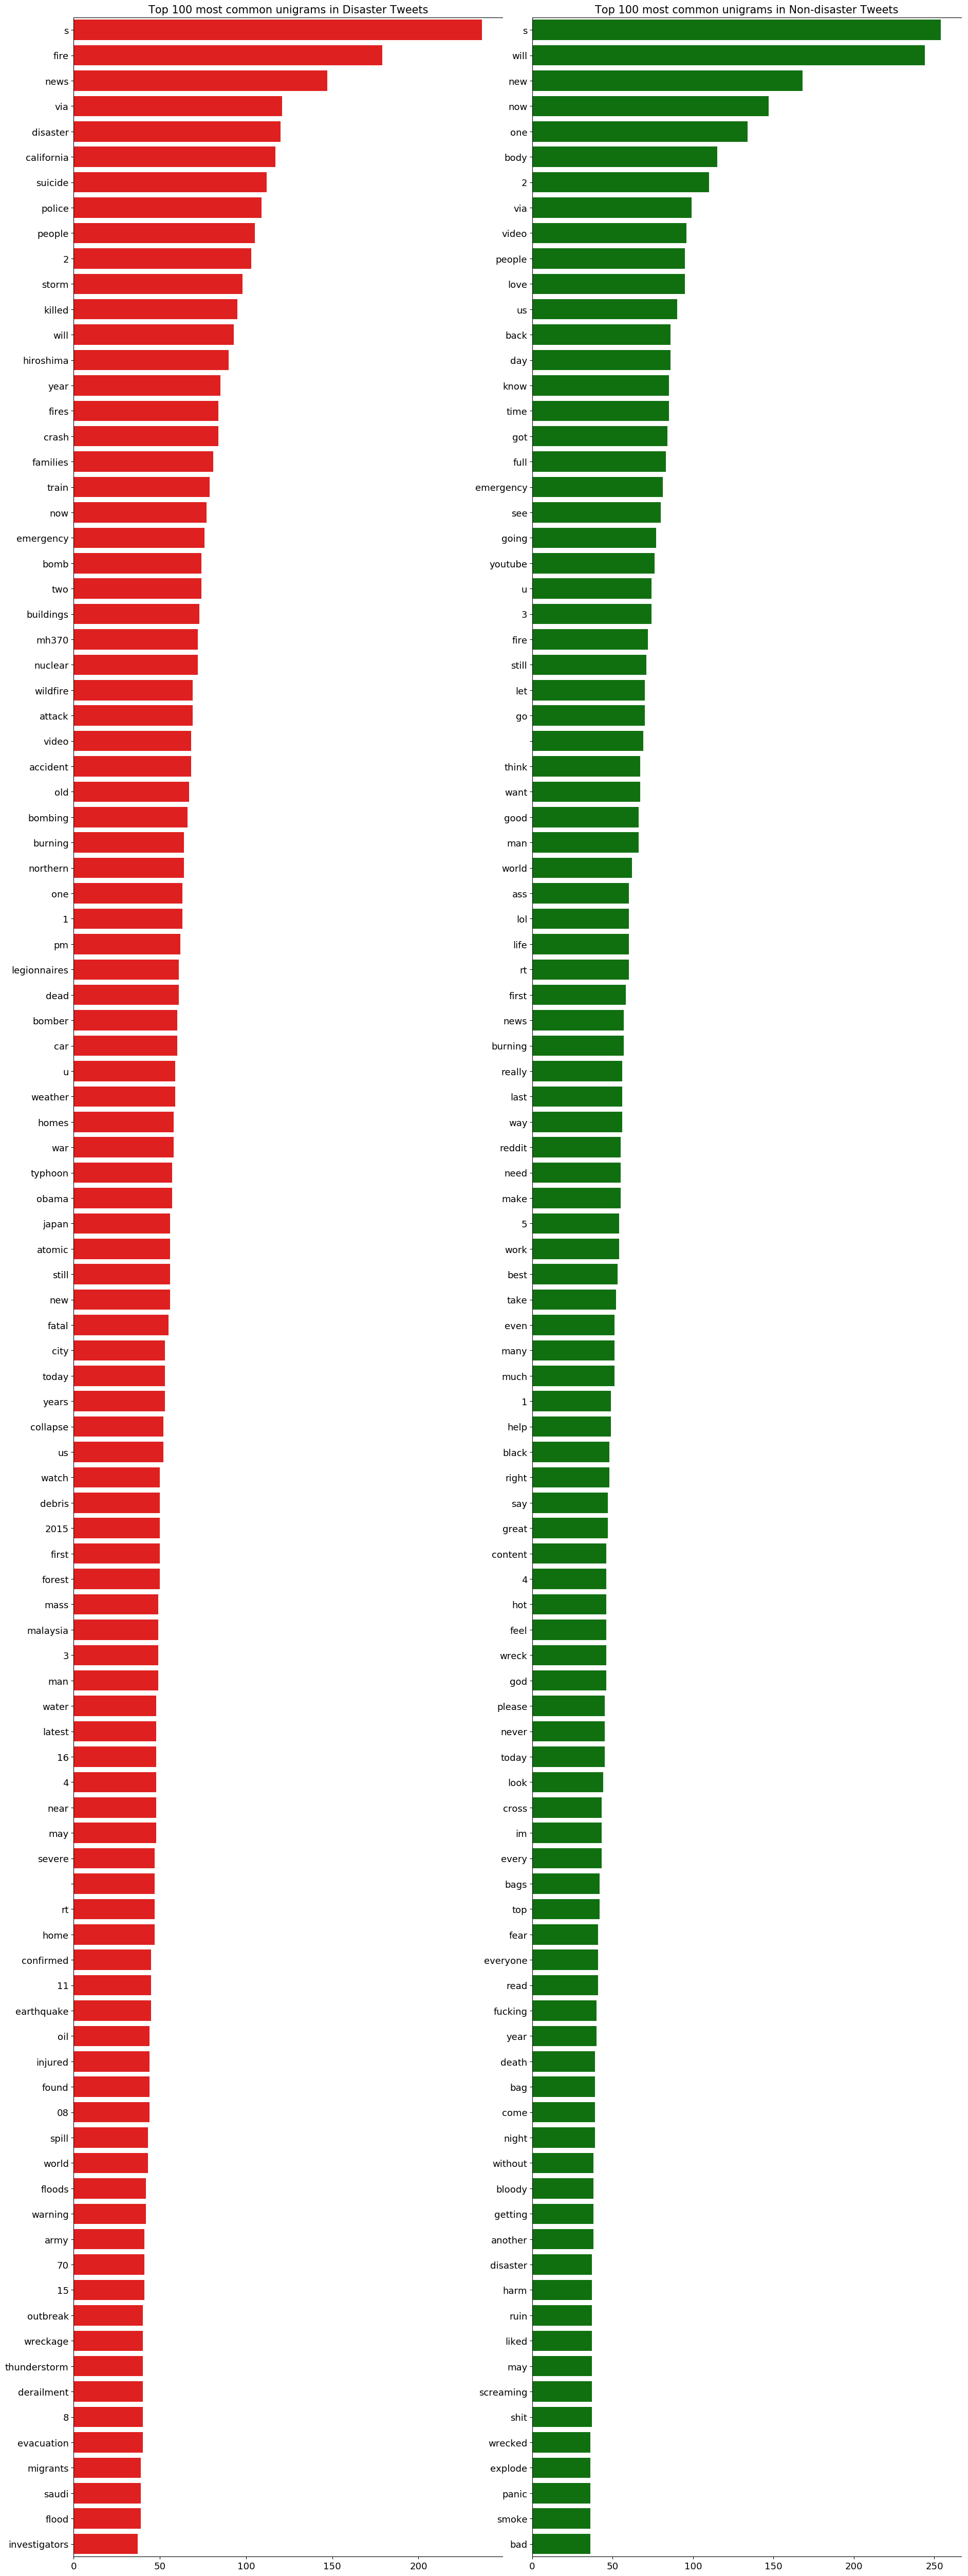

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

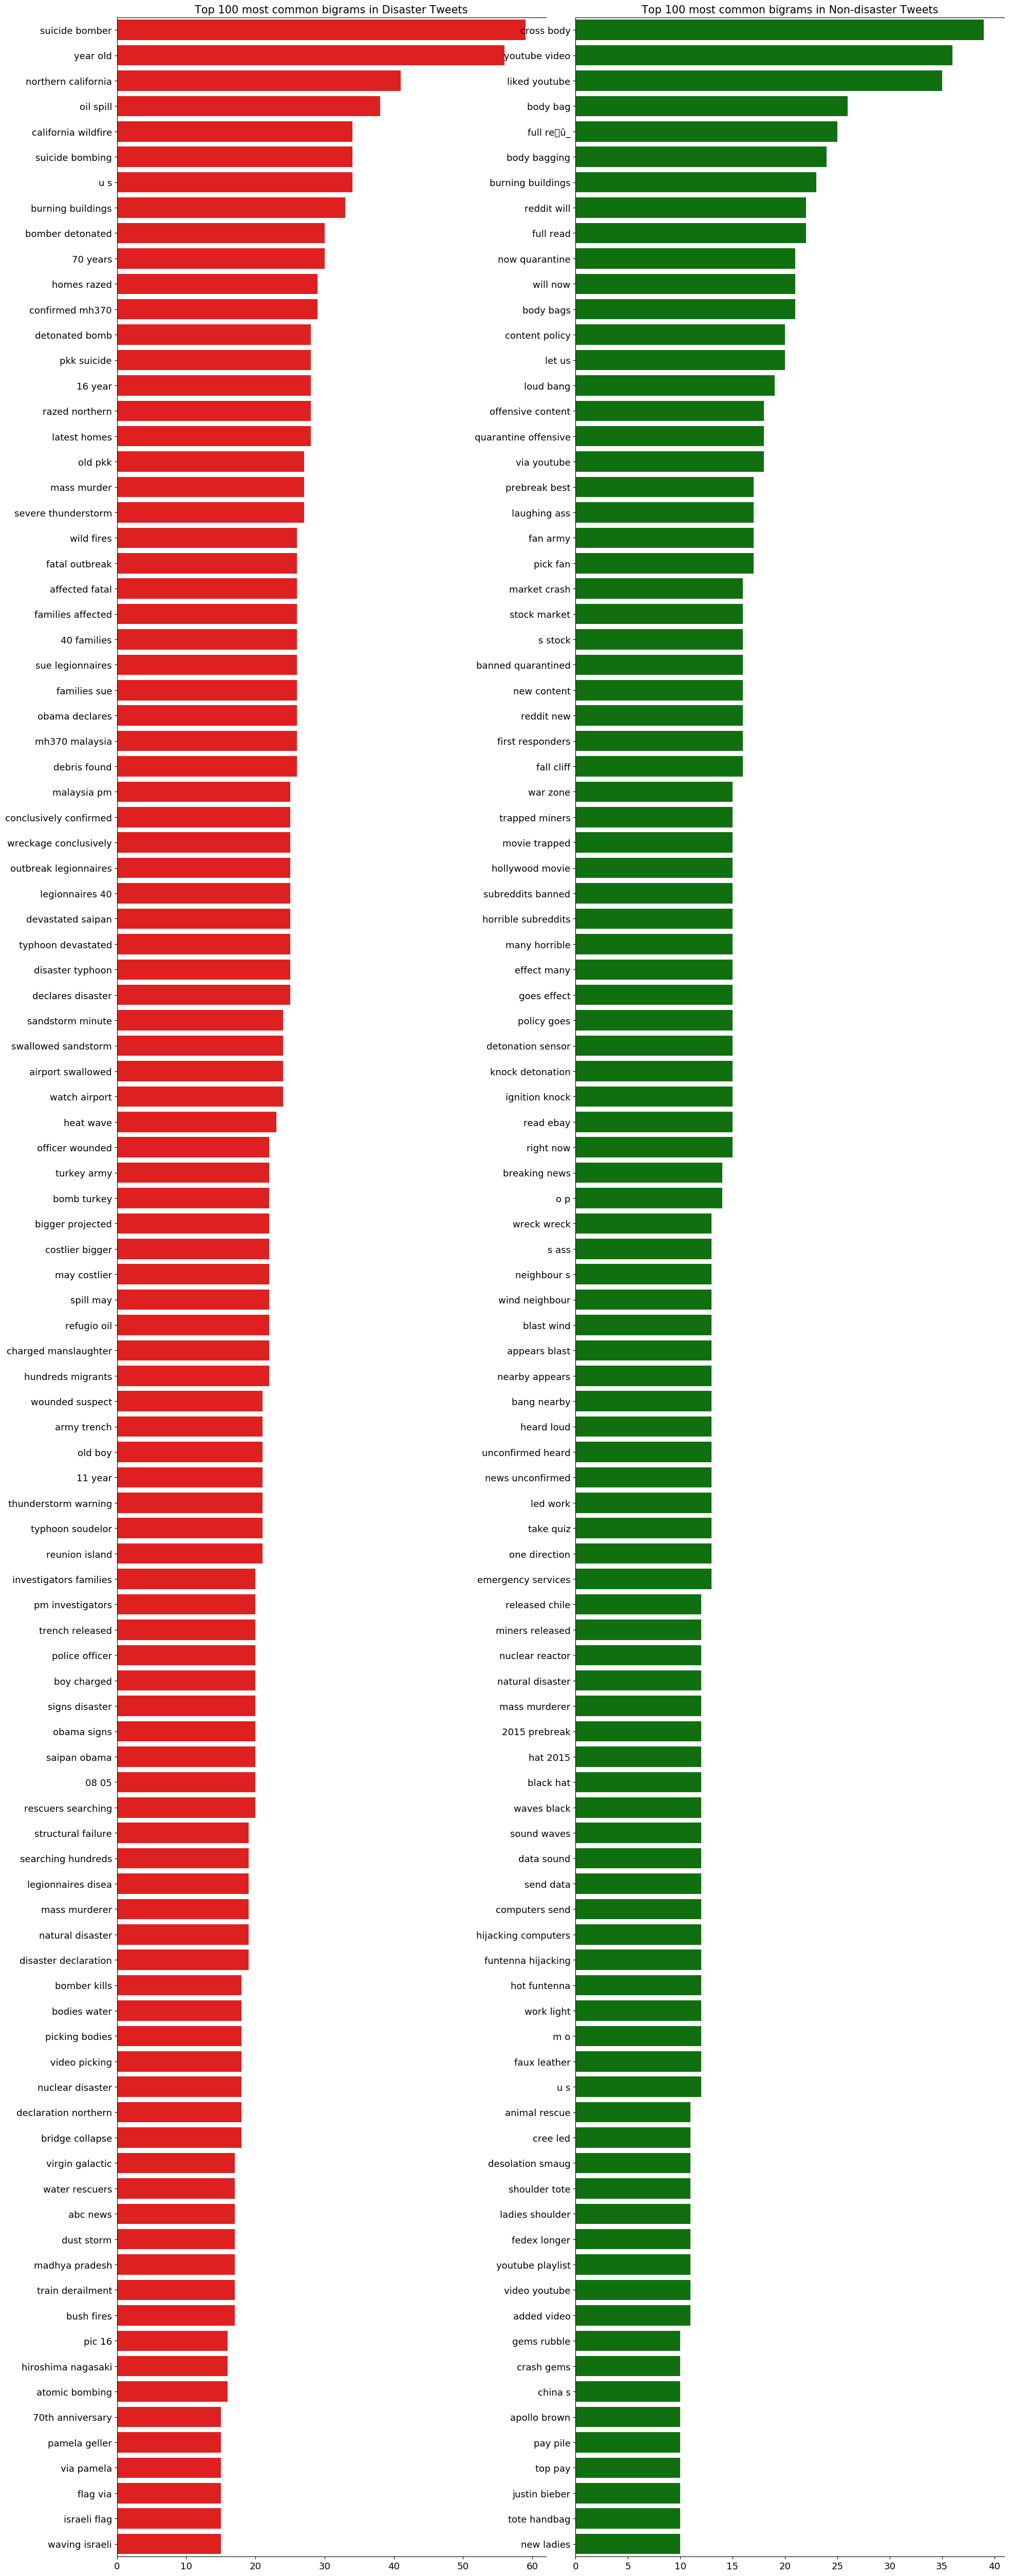

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

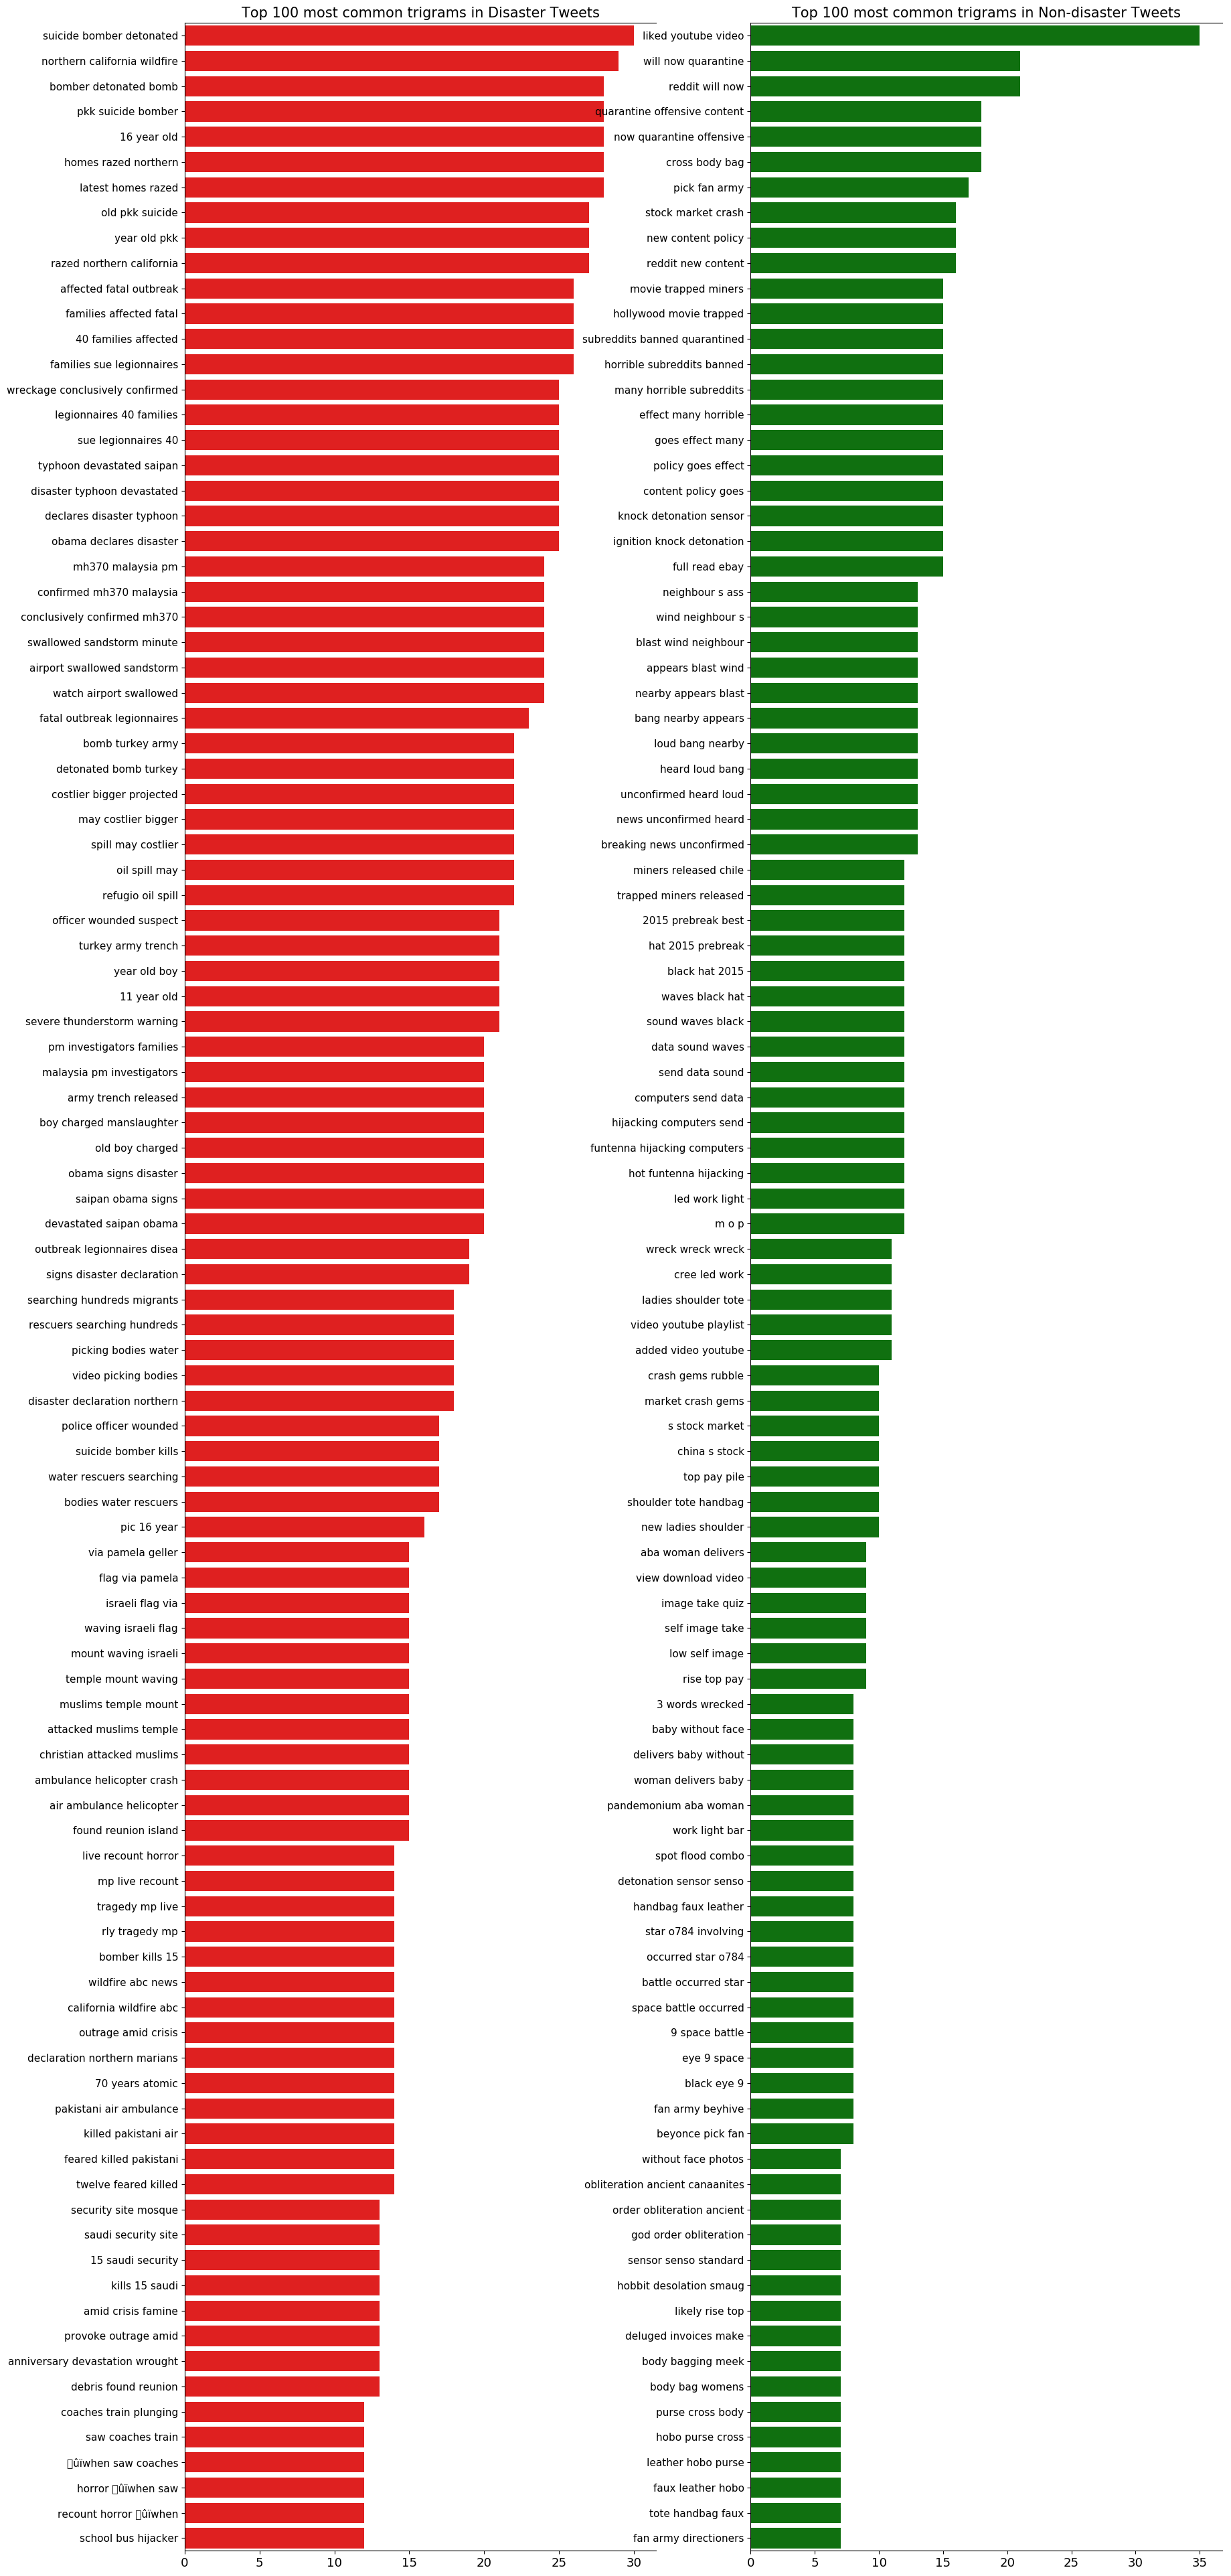

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [22]:
#train_df = df_full[df_full['target']!=-1]
#test_df = df_full[df_full['target']==-1]

print(train_df.shape)
print(test_df.shape)
print(df_full.shape)

del df_full
del test_df['target']
reduce_memory_usage(train_df)
reduce_memory_usage(test_df)
gc.collect()


(7613, 15)
(3263, 15)
(10876, 15)
Column 'id' converted from int64 to int16
Column 'target' converted from int64 to int8
Column 'word_cnt' converted from int64 to int8
Column 'unique_word_cnt' converted from int64 to int8
Column 'stop_word_cnt' converted from int64 to int8
Column 'url_cnt' converted from int64 to int8
Column 'mean_word_len' converted from float64 to float32
Column 'char_cnt' converted from int64 to int16
Column 'punc_cnt' converted from int64 to int8
Column 'hash_cnt' converted from int64 to int8
Column 'mention_cnt' converted from int64 to int8
Memory usage decreased from 4.05MB to 3.53MB (0.52MB, 12.90% reduction)
Column 'id' converted from int64 to int16
Column 'word_cnt' converted from int64 to int8
Column 'unique_word_cnt' converted from int64 to int8
Column 'stop_word_cnt' converted from int64 to int8
Column 'url_cnt' converted from int64 to int8
Column 'mean_word_len' converted from float64 to float32
Column 'char_cnt' converted from int64 to int16
Column 'punc_

37656

**Load and Preprocess**
* Load BERT from the Tensorflow Hub
* Load tokenizer from the bert layer
* Encode the text into tokens, masks, and segment flags

In [23]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 1min 26s, sys: 9.32 s, total: 1min 35s
Wall time: 1min 39s


In [24]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [25]:
train_input = bert_encode(train_df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_df.text.values, tokenizer, max_len=160)
train_labels = train_df.target.values

In [26]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [27]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=4,
    batch_size=16
)

model.save('bert_model.h5')

Train on 6090 samples, validate on 1523 samples
Epoch 1/4
6090/6090 [==============================] - 398s 65ms/sample - loss: 0.4629 - accuracy: 0.7862 - val_loss: 0.3983 - val_accuracy: 0.8313
Epoch 2/4
6090/6090 [==============================] - 354s 58ms/sample - loss: 0.3331 - accuracy: 0.8606 - val_loss: 0.4102 - val_accuracy: 0.8286
Epoch 3/4
6090/6090 [==============================] - 354s 58ms/sample - loss: 0.2410 - accuracy: 0.9051 - val_loss: 0.4427 - val_accuracy: 0.8234
Epoch 4/4
6090/6090 [==============================] - 354s 58ms/sample - loss: 0.1575 - accuracy: 0.9440 - val_loss: 0.4861 - val_accuracy: 0.8214


In [28]:
test_pred = model.predict(test_input)

In [29]:
sub_df['target'] = test_pred.round().astype(int)
sub_df.to_csv('submission_bert.csv', index=False)